In [1]:
import numpy as np
import pymc3 as pm

import pandas as pd
from scipy.special import logit, expit

import matplotlib.pyplot as plt

In [2]:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(10)])

In [3]:
df = pd.read_csv('../data/41586_2019_917_MOESM4_ESM.csv')

In [4]:
#these are the docking scores:
df['Energy'] = np.array(df['Energy'].str.strip('¶')).astype(float)

#set the "not determined" records to zero inhibition:
df.loc[df['Inhibition (%) at 10uM'].str.contains('ND'), 'Inhibition (%) at 10uM'] = 0


In [5]:
#this simply uses argsort (twice) to find the 1-indexed rank of each score, including
#the ligands used in _in vitro_ validation. Ranks are then normalized by dividing by 
#number of items

normalized_ranks = ( (np.concatenate([scores, df['Energy']]).argsort().argsort()+1) /\
                ((scores.shape[0]+df['Energy'].shape[0]) - 1) )

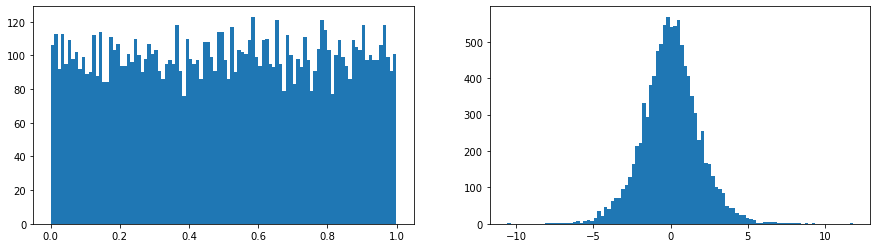

In [6]:
#we can see that the logit(normalized_ranks) are normally distrubuted, 
#which is what you would expect when logit-transforming a uniformly-distributed

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

_ = ax[0].hist(np.random.choice(normalized_ranks, 10000), bins=100)
_ = ax[1].hist(logit(np.random.choice(normalized_ranks, 10000)), bins=100)

In [7]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]

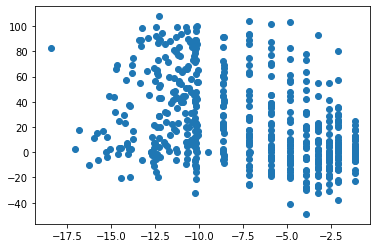

In [8]:
#observe that this resembles Lyu et al, except the points at the bottom of the 
#curve are bunched a bit closer. This more accurately represents
#where the tested range sits in comparison to the rest of the distribution.


plt.scatter(logit(ranks), df['Inhibition (%) at 10uM'].values.astype(float))

In [9]:
logit_nranks = logit(ranks)
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50

with pm.Model() as model:
    #priors
    middle = pm.Normal('middle', mu=0, sigma=30)
    slope = pm.Normal('slope', mu=0, sigma=6)
    #height = pm.Beta('height', 2,2)
    height = pm.Beta('height', 35/5,65/5)
    
    #sigmoid:
    proportion = height * pm.Deterministic('proportion', pm.math.sigmoid(slope*(logit_nranks + middle)))

    #likelihood
    observed = pm.Bernoulli('hits', proportion, observed=hits)
    
    trace = pm.sample(20_000, tune=3000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [height, slope, middle]


Sampling 4 chains for 3_000 tune and 20_000 draw iterations (12_000 + 80_000 draws total) took 21 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [10]:
print('Middle HPD:')
print(-pm.stats.hpd(trace['middle']))
print(expit(-pm.stats.hpd(trace['middle']))*100)

Middle HPD:
[-4.16668168 -6.97832459]
[1.52669282 0.09309956]


/home/lewis/miniconda3/envs/dockop/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


In [24]:
expit(-np.mean(trace['middle'])) * 100

0.39416989384309226

In [27]:
np.mean(trace['middle'])

5.532193958057719

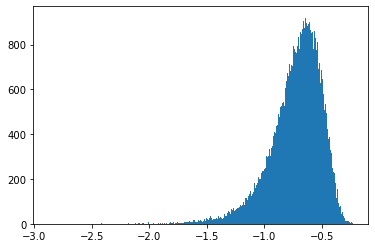

In [11]:
_ =plt.hist(trace['slope'], bins=500)

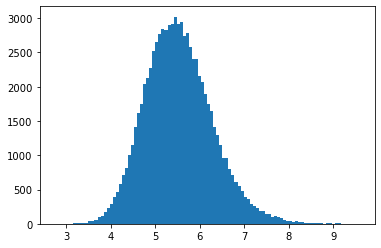

In [12]:
_ =plt.hist(trace['middle'], bins=100)

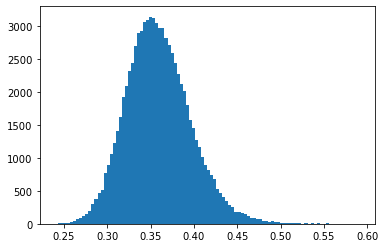

In [13]:
_ = plt.hist(trace['height'],bins=100)

In [44]:
from altair import expr, datum
import altair as alt

x = np.linspace(-16, 2, 100)
line_source = pd.DataFrame({'Score':x})
base = alt.Chart(line_source).mark_line(color='gray', opacity=0.1).encode(
    x = alt.X('Score:Q', title='logit(Rank)'),
    y = alt.Y('Hit rate:Q', title='Hit rate')
)

lines = []
for i in range(300):
    sample_idx = np.random.choice(trace['height'].shape[0])
    height =trace['height'][sample_idx]
    slope = trace['slope'][sample_idx]
    middle = trace['middle'][sample_idx]
    
    lines.append(base.transform_calculate(
        as_='Hit rate', 
        calculate = height * 1/ (1 + expr.exp( - (middle+datum.Score)*slope))
    ))
    
    

hline2 = alt.Chart(line_source).mark_rule(size=0.2, strokeDash=[5, 5]).encode(
    x=alt.X('hline2:Q', title='logit(Rank)'),
)

ch = alt.layer(base, *lines, hline2,).transform_calculate(hline2="-5.5")
ch

alt.LayerChart(...)

In [45]:
ch.save('../figures/hit_rate_vs_rank.html')